<a href="https://colab.research.google.com/github/turnleftorgo/Deep_learning/blob/main/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start with Helper functions

In [ ]:
!pip install torchinfo

In [ ]:
# import library
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timm.models.layers import DropPath, Mlp, PatchEmbed
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets
from torchvision.datasets import OxfordIIITPet, wrap_dataset_for_transforms_v2
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42) # For reproduciblity purpose, please do not modify this.

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# You can change input params of this function if needed
def load_pet_data(data_dir, batch_size=64, img_height=224, img_width=224, transform=None):

    # Define transforms
    if transform is None:
      transform = v2.Compose([
              v2.ToImage(),
              v2.Resize((img_height, img_width), interpolation=InterpolationMode.BICUBIC),
              v2.ToDtype(torch.float32, scale=True),
          ])

    train_ds = OxfordIIITPet(
        root=data_dir,
        split="trainval",
        download=True,
        transform=transform,
    )

    val_ds = OxfordIIITPet(
        root=data_dir,
        split="test",
        download=True,
        transform=transform,
    )

    print(f"Number of training samples: {len(train_ds)}")
    print(f"Number of validation samples: {len(val_ds)}")

    # Create DataLoader instances
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, 37


# Vision Transformer (ViT)


In [ ]:
def swish(x, beta):
    return x * torch.sigmoid(x * beta)


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)

        attention = (q @ k.transpose(-2, -1)) * self.scale
        attention = attention.softmax(dim=-1)
        attention = self.attn_drop(attention)

        x = (attention @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class ViTLayer(nn.Module):

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attention = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.ffn = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x):
        x = x + self.drop_path(self.attention(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4.0,
        qkv_bias=True,
        distilled=False,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        embed_layer=PatchEmbed,
    ):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
        """
        super().__init__()
        self.num_features = self.embed_dim = (
            embed_dim  # num_features for consistency with other models
        )
        self.num_tokens = 2 if distilled else 1
        norm_layer = nn.LayerNorm
        act_layer = nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = (
            nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        )
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + self.num_tokens, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.drop_rate = drop_rate
        self.attn_drop_rate = attn_drop_rate

        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # stochastic depth decay rule

        self.layers = nn.Sequential(
            *[
                ViTLayer(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                )
                for i in range(depth)                                                # depth=12
            ]
        )

        self.norm = norm_layer(embed_dim)

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, 1000)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token"}

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat(
                (cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1
            )
        x = self.pos_drop(x + self.pos_embed)

        x = self.layers(x)

        x = self.norm(x[:, 0]) # take cls token

        x = self.norm(x)
        out = self.head(x)
        return out

# Task 3: Fine-tuning (a part of) the ViT Model (3 marks)

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF
From (redirected): https://drive.google.com/uc?id=1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF&confirm=t&uuid=04365cba-b4c8-4303-bb63-c279392cee48
To: /content/pretrained_vit_small.pth
100% 88.3M/88.3M [00:01<00:00, 47.8MB/s]


In [ ]:
batch_size = 32 # Set this to your preferred values.

small_vit = VisionTransformer()

# Load the pretrained ImageNet weight
missing, unexpected = small_vit.load_state_dict(torch.load("./pretrained_vit_small.pth"))

print("Missing:", missing)
print("Unexpected:", unexpected)

# Replace with a new head for transfer learning.
# Hidden dimension of 384, 37 classes for the OxfordIIITPet dataset

small_vit.head = nn.Linear(384, 37)
small_vit.to(device)

Missing: []
Unexpected: []


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): ViTLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attention): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ffn): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
 

In [ ]:
summary(small_vit, (batch_size, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [32, 37]                  76,032
├─PatchEmbed: 1-1                        [32, 196, 384]            --
│    └─Conv2d: 2-1                       [32, 384, 14, 14]         295,296
│    └─Identity: 2-2                     [32, 196, 384]            --
├─Dropout: 1-2                           [32, 197, 384]            --
├─Sequential: 1-3                        [32, 197, 384]            --
│    └─ViTLayer: 2-3                     [32, 197, 384]            --
│    │    └─LayerNorm: 3-1               [32, 197, 384]            768
│    │    └─Attention: 3-2               [32, 197, 384]            591,360
│    │    └─Identity: 3-3                [32, 197, 384]            --
│    │    └─LayerNorm: 3-4               [32, 197, 384]            768
│    │    └─Mlp: 3-5                     [32, 197, 384]            1,181,568
│    │    └─Identity: 3-6                [32, 197, 384]       

## Training process

In [ ]:
# Get the dataloaders for training
train_dataloader, val_dataloader, num_classes = load_pet_data(data_dir="./", batch_size=batch_size)

Number of training samples: 3680
Number of validation samples: 3669


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    history: dict with keys
      'train_loss', 'val_loss', 'train_acc', 'val_acc'
      each a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_loss(model, loss_fn, loader):
    loss = 0
    model.eval()
    with torch.no_grad():
        for (batchX, batchY) in loader:
            batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
            loss += loss_fn(model(batchX), batchY)
    model.train()
    return float(loss) / len(loader)

In [ ]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    model.eval()
    for (batchX, batchY) in loader:
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)
        totals += batchY.size(0)
        predicted = torch.argmax(outputs.data, 1)
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [ ]:
def fit(model=None, train_loader=None, valid_loader=None, optimizer=None,
        num_epochs=50, loss_fn=nn.CrossEntropyLoss(), verbose=True, seed=1234, device=None):

    model.to(device)

    if optimizer is None:
        optim = torch.optim.Adam(model.parameters(), lr=0.001)
    else:
        optim = optimizer

    history = {}
    history['val_loss'] = []
    history['val_acc'] = []
    history['train_loss'] = []
    history['train_acc'] = []

    best_test_acc = -1

    for epoch in range(num_epochs):


        model.train()

        for (X, y) in train_loader:

            X, y = X.to(device), y.to(device)
            outputs = model(X.type(torch.float32))
            loss = loss_fn(outputs, y.type(torch.long))
            optim.zero_grad()
            loss.backward()
            optim.step()

        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_loss = compute_loss(model, loss_fn, train_loader)
        train_acc = compute_acc(model, train_loader)



        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

        if val_acc > best_test_acc:
            best_test_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"the best test accuracy so far is {best_test_acc:.4f}")

    return history

## Partial fine-tuning

In [ ]:
"""tune the Top-K"""

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
for param in small_vit.parameters():
    param.requires_grad = False

num_blocks = len(small_vit.layers)

for i in range(num_blocks - 3, num_blocks):
    for param in small_vit.layers[i].parameters():
        param.requires_grad = True

for param in small_vit.norm.parameters():
    param.requires_grad = True

for param in small_vit.head.parameters():
    param.requires_grad = True

total, trainable = count_parameters(small_vit)
print(f"[Partial FT] Total params: {total:,}, Trainable params: {trainable:,}")

[Partial FT] Total params: 21,679,909, Trainable params: 5,338,405


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10

optimizer = torch.optim.AdamW(small_vit.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

history1 = fit(model= small_vit, train_loader=train_dataloader, valid_loader = val_dataloader, optimizer = optimizer, num_epochs=num_epochs, verbose = True, device=device, loss_fn=loss_fn)

Epoch 1/10
train loss= 0.3187 - train acc= 90.00% - valid loss= 0.5263 - valid acc= 83.24%
the best test accuracy so far is 0.8324
Epoch 2/10
train loss= 0.3076 - train acc= 90.87% - valid loss= 0.5024 - valid acc= 85.36%
the best test accuracy so far is 0.8536
Epoch 3/10
train loss= 0.2685 - train acc= 90.84% - valid loss= 0.5006 - valid acc= 83.32%
Epoch 4/10
train loss= 0.2015 - train acc= 92.91% - valid loss= 0.4752 - valid acc= 84.44%
Epoch 5/10
train loss= 0.1500 - train acc= 94.40% - valid loss= 0.4224 - valid acc= 86.51%
the best test accuracy so far is 0.8651
Epoch 6/10
train loss= 0.1312 - train acc= 95.73% - valid loss= 0.3903 - valid acc= 87.82%
the best test accuracy so far is 0.8782
Epoch 7/10
train loss= 0.1233 - train acc= 96.09% - valid loss= 0.4068 - valid acc= 87.52%
Epoch 8/10
train loss= 0.1392 - train acc= 95.19% - valid loss= 0.4620 - valid acc= 85.42%
Epoch 9/10
train loss= 0.1094 - train acc= 96.06% - valid loss= 0.4229 - valid acc= 86.37%
Epoch 10/10
train los

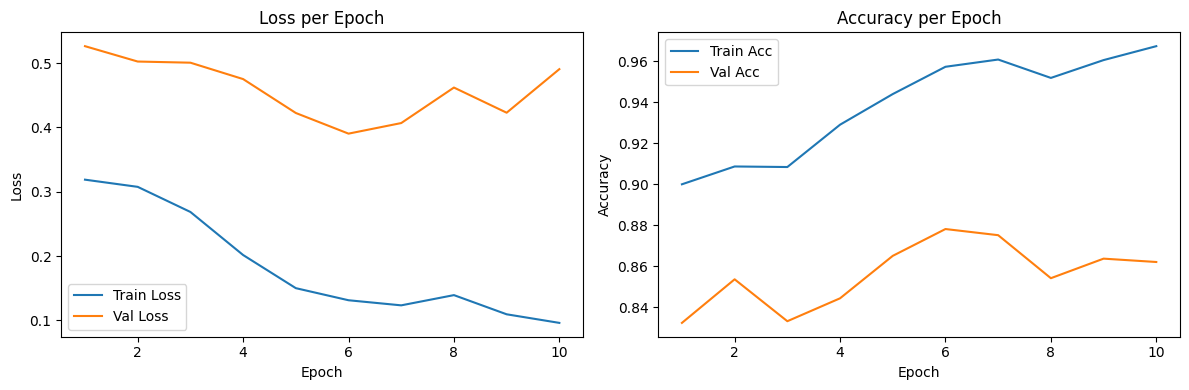

In [ ]:
plot_history(history1)

## full fine-tuning

In [ ]:
for param in small_vit.parameters():
    param.requires_grad = True

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(small_vit)
print(f"[Partial FT] Total params: {total:,}, Trainable params: {trainable:,}")

[Partial FT] Total params: 21,679,909, Trainable params: 21,679,909


In [ ]:
learning_rate = 0.00001
weight_decay = 0.001
num_epochs = 10

optimizer = torch.optim.AdamW(small_vit.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

history2 = fit(model= small_vit, train_loader=train_dataloader, valid_loader = val_dataloader, optimizer = optimizer, num_epochs=num_epochs, verbose = True, device=device, loss_fn=loss_fn)

Epoch 1/10
train loss= 2.7990 - train acc= 22.45% - valid loss= 2.8990 - valid acc= 19.65%
the best test accuracy so far is 0.1965
Epoch 2/10
train loss= 1.6919 - train acc= 55.24% - valid loss= 1.8438 - valid acc= 49.36%
the best test accuracy so far is 0.4936
Epoch 3/10
train loss= 1.0412 - train acc= 75.52% - valid loss= 1.2016 - valid acc= 68.60%
the best test accuracy so far is 0.6860
Epoch 4/10
train loss= 0.7147 - train acc= 83.51% - valid loss= 0.8739 - valid acc= 77.08%
the best test accuracy so far is 0.7708
Epoch 5/10
train loss= 0.5289 - train acc= 88.18% - valid loss= 0.6862 - valid acc= 81.47%
the best test accuracy so far is 0.8147
Epoch 6/10
train loss= 0.4233 - train acc= 90.98% - valid loss= 0.5878 - valid acc= 83.65%
the best test accuracy so far is 0.8365
Epoch 7/10
train loss= 0.3474 - train acc= 92.15% - valid loss= 0.5165 - valid acc= 85.34%
the best test accuracy so far is 0.8534
Epoch 8/10
train loss= 0.2885 - train acc= 93.89% - valid loss= 0.4586 - valid acc=

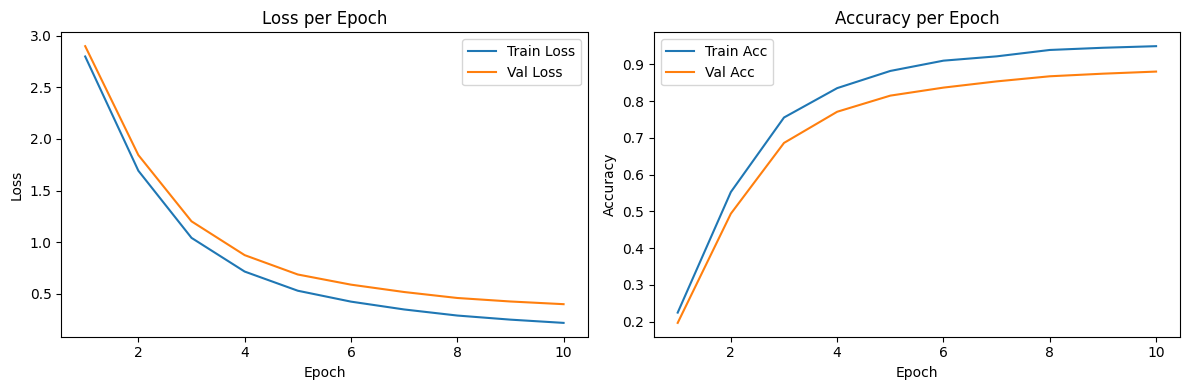

In [ ]:
plot_history(history2)

# Task 4: Explore and Implement a Parameter-Efficient Transfer Learning (PETL) Technique (4 marks)

In [ ]:
import math

class Adapter(nn.Module):
    def __init__(self, dim: int, bottleneck: int = 64, dropout: float = 0.1):
        super().__init__()
        self.down = nn.Linear(dim, bottleneck, bias=False)
        self.nonlin = nn.ReLU()
        self.up = nn.Linear(bottleneck, dim, bias=False)
        self.dropout = nn.Dropout(dropout)


        nn.init.kaiming_uniform_(self.down.weight, a=math.sqrt(5))
        nn.init.zeros_(self.up.weight)

    def forward(self, x):
        return self.up(self.dropout(self.nonlin(self.down(x))))

In [ ]:
def swish(x, beta):
    return x * torch.sigmoid(x * beta)


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)

        attention = (q @ k.transpose(-2, -1)) * self.scale
        attention = attention.softmax(dim=-1)
        attention = self.attn_drop(attention)

        x = (attention @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
class ViTLayer_Max(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer: nn.Module = nn.LayerNorm,
        use_adapter: bool = True,
        adapter_dim: int = 64,
    ):
        super().__init__()
        # Attention branch
        self.norm1 = norm_layer(dim)
        self.attention = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        #  FFN branch
        self.norm2 = norm_layer(dim)
        hidden = int(dim * mlp_ratio)
        self.ffn = Mlp(
            in_features=dim,
            hidden_features=hidden,
            act_layer=act_layer,
            drop=drop,
        )

        #  Adapter
        self.use_adapter = use_adapter
        if use_adapter:
            self.adapter = Adapter(dim, bottleneck=adapter_dim, dropout=drop)

    def forward(self, x):
        # Multi-Head Self-Attention
        x = x + self.drop_path(self.attention(self.norm1(x)))

        if self.use_adapter:
            adapter_x = self.adapter(x)

        # Feed-Forward
        x = x + self.drop_path(self.ffn(self.norm2(x)))

        # Adapter
        if self.use_adapter:
            x = x + adapter_x

        return x




In [ ]:
class VisionTransformer_Max(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 384,
        depth: int = 12,
        num_heads: int = 6,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.2,
        embed_layer: nn.Module = PatchEmbed,
        adapter_dim: int = 64,
        use_adapter: bool = True,
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim


        self.patch_embed = embed_layer(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        num_patches = self.patch_embed.num_patches


        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)


        dpr = torch.linspace(0, drop_path_rate, depth).tolist()
        self.layers = nn.Sequential(
            *[
                ViTLayer_Max(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    use_adapter=use_adapter,
                    adapter_dim=adapter_dim,
                )
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim)


        self.head = nn.Linear(embed_dim, 1000)


    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token"}

    def forward_features(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.layers(x)
        return self.norm(x[:, 0])

    def forward(self, x):
        return self.head(self.forward_features(x))

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF
From (redirected): https://drive.google.com/uc?id=1ZO12-Sl6f3_BBlgbH9HN6cICmLr6JQVF&confirm=t&uuid=c14738cf-e914-4b4a-b612-a85d16bf2006
To: /content/pretrained_vit_small.pth
100% 88.3M/88.3M [00:01<00:00, 61.0MB/s]


In [ ]:
batch_size = 32

ViT = VisionTransformer_Max(use_adapter=True,adapter_dim=64)

state = torch.load("pretrained_vit_small.pth")
missing, unexpected = ViT.load_state_dict(state, strict=False)




print("Missing:", missing)
print("Unexpected:", unexpected)



ViT.head = nn.Linear(384, 37)
ViT.to(device)

Missing: ['layers.0.adapter.down.weight', 'layers.0.adapter.up.weight', 'layers.1.adapter.down.weight', 'layers.1.adapter.up.weight', 'layers.2.adapter.down.weight', 'layers.2.adapter.up.weight', 'layers.3.adapter.down.weight', 'layers.3.adapter.up.weight', 'layers.4.adapter.down.weight', 'layers.4.adapter.up.weight', 'layers.5.adapter.down.weight', 'layers.5.adapter.up.weight', 'layers.6.adapter.down.weight', 'layers.6.adapter.up.weight', 'layers.7.adapter.down.weight', 'layers.7.adapter.up.weight', 'layers.8.adapter.down.weight', 'layers.8.adapter.up.weight', 'layers.9.adapter.down.weight', 'layers.9.adapter.up.weight', 'layers.10.adapter.down.weight', 'layers.10.adapter.up.weight', 'layers.11.adapter.down.weight', 'layers.11.adapter.up.weight']
Unexpected: []


VisionTransformer_Max(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): ViTLayer_Max(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attention): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ffn): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
 

In [ ]:

for name, param in ViT.named_parameters():

    if ("adapter." in name) or name.startswith("head"):
        param.requires_grad_(True)
    else:
        param.requires_grad_(False)


def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_parameters(ViT)
print(f"[Partial FT] Total params: {total:,}, Trainable params: {trainable:,}")


[Partial FT] Total params: 22,269,733, Trainable params: 604,069


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10

optimizer = torch.optim.AdamW(ViT.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

history3 = fit(model= ViT, train_loader=train_dataloader, valid_loader = val_dataloader, optimizer = optimizer, num_epochs=num_epochs, verbose = True, device=device, loss_fn=loss_fn)

Epoch 1/10
train loss= 0.3891 - train acc= 86.06% - valid loss= 0.5060 - valid acc= 81.30%
the best test accuracy so far is 0.8130
Epoch 2/10
train loss= 0.2033 - train acc= 93.10% - valid loss= 0.3623 - valid acc= 87.46%
the best test accuracy so far is 0.8746
Epoch 3/10
train loss= 0.1759 - train acc= 93.75% - valid loss= 0.4039 - valid acc= 87.30%
Epoch 4/10
train loss= 0.1110 - train acc= 96.03% - valid loss= 0.2894 - valid acc= 90.19%
the best test accuracy so far is 0.9019
Epoch 5/10
train loss= 0.1001 - train acc= 96.49% - valid loss= 0.3652 - valid acc= 88.83%
Epoch 6/10
train loss= 0.0587 - train acc= 98.07% - valid loss= 0.3094 - valid acc= 90.24%
the best test accuracy so far is 0.9024
Epoch 7/10
train loss= 0.0605 - train acc= 97.77% - valid loss= 0.3640 - valid acc= 89.07%
Epoch 8/10
train loss= 0.0356 - train acc= 98.80% - valid loss= 0.3385 - valid acc= 90.46%
the best test accuracy so far is 0.9046
Epoch 9/10
train loss= 0.0431 - train acc= 98.32% - valid loss= 0.3599 -

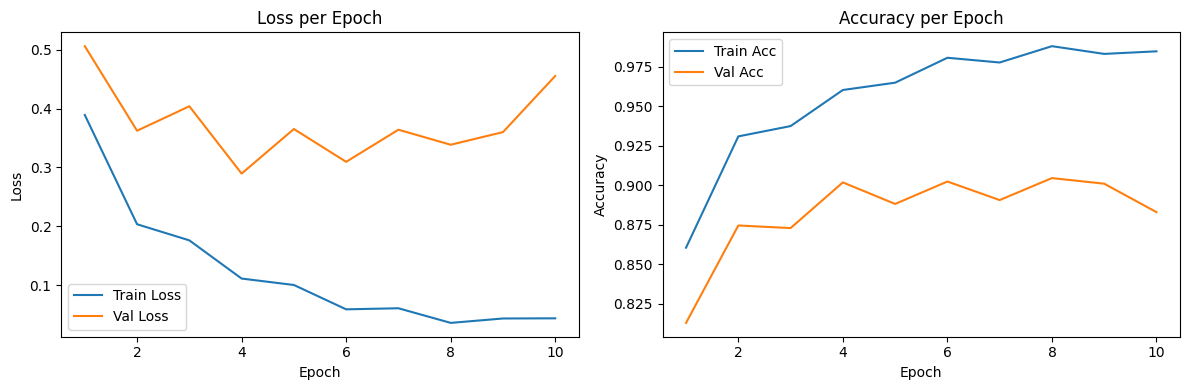

In [ ]:
plot_history(history3)